BatchGD training time: 17.37 seconds
SGD training time: 37.89 seconds
MiniBatch training time: 53.53 seconds
Momentum training time: 9.19 seconds
Nesterov training time: 9.86 seconds


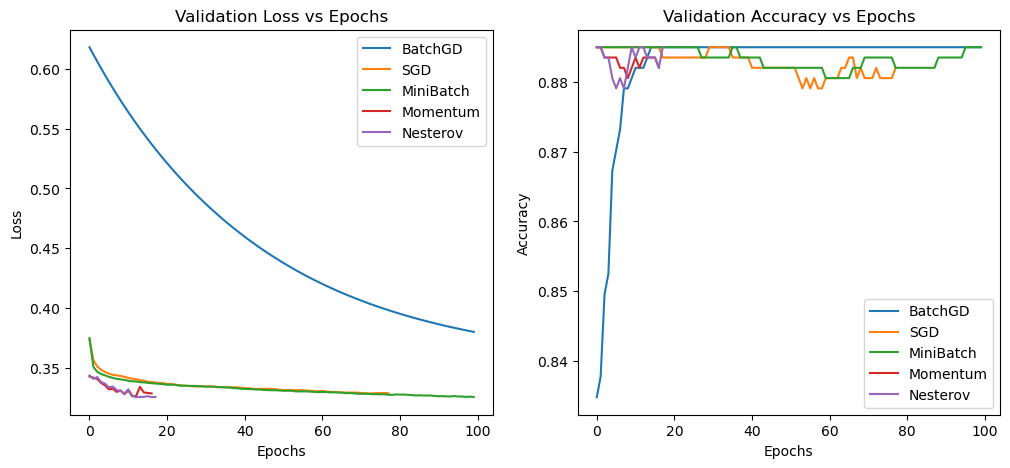

MiniBatch-16 training time: 33.88 seconds
MiniBatch-64 training time: 33.37 seconds
MiniBatch-256 training time: 18.82 seconds
SGD-lr0.001 training time: 49.21 seconds
SGD-lr0.01 training time: 34.27 seconds
SGD-lr0.1 training time: 9.03 seconds
Momentum-0.5 training time: 41.68 seconds
Momentum-0.9 training time: 17.13 seconds
Momentum-0.99 training time: 6.62 seconds
Nesterov-0.5 training time: 24.75 seconds
Nesterov-0.9 training time: 9.01 seconds
Nesterov-0.99 training time: 5.11 seconds
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Final Test Evaluation:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       601
           1       0.65      0.17      0.27        78

    accuracy                           0.89       679
   macro avg       0.78      0.58      0.60       679
weighted avg       0.87      0.89      0.87       679

Confusion Matrix:
[[594   7]
 [ 65  13]]


In [1]:
# ================================
# Bank Marketing DNN Experiment
# ================================

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix

# -------------------------------
# 1. Load and Preprocess Dataset
# -------------------------------
data = pd.read_csv(r"Z:\bank.csv", sep=";")

# Target column is 'y'
y = (data["y"] == "yes").astype(int)
X = data.drop("y", axis=1)

# Handle missing values
X["contact"] = X["contact"].fillna("unknown")
X["poutcome"] = X["poutcome"].fillna("nonexistent")

# Drop duration for realistic predictive modeling
X = X.drop("duration", axis=1)

# Define variable groups
categorical_cols = ["job","marital","education","contact","month","poutcome"]
numeric_cols = ["age","balance","campaign","pdays","previous","day"]
binary_cols = ["default","housing","loan"]

# Convert binary yes/no to 0/1
for col in binary_cols:
    X[col] = X[col].map({"yes":1,"no":0})

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ],
    remainder="passthrough"  # keep binary columns
)

X_processed = preprocessor.fit_transform(X)

# Train/Val/Test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_processed, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# -------------------------------
# 2. Define DNN Model
# -------------------------------
def build_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),   # Explicit Input layer
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

# -------------------------------
# 3. Training Function
# -------------------------------
def train_with_optimizer(optimizer, name, X_train, y_train, X_val, y_val, batch_size=32):
    model = build_model(X_train.shape[1])
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )
    
    start = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )
    end = time.time()
    
    print(f"{name} training time: {end-start:.2f} seconds")
    return model, history

# -------------------------------
# 4. Optimizer Experiments
# -------------------------------
optimizers = {
    "BatchGD": tf.keras.optimizers.SGD(learning_rate=0.01),
    "SGD": tf.keras.optimizers.SGD(learning_rate=0.01),
    "MiniBatch": tf.keras.optimizers.SGD(learning_rate=0.01),
    "Momentum": tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    "Nesterov": tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
}

histories = {}
trained_models = {}

for name, opt in optimizers.items():
    bs = len(X_train) if name == "BatchGD" else 32
    model, history = train_with_optimizer(opt, name, X_train, y_train, X_val, y_val, batch_size=bs)
    histories[name] = history
    trained_models[name] = model

# -------------------------------
# 5. Comparative Plots
# -------------------------------
plt.figure(figsize=(12,5))

# Loss comparison
plt.subplot(1,2,1)
for name, hist in histories.items():
    plt.plot(hist.history["val_loss"], label=name)
plt.title("Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy comparison
plt.subplot(1,2,2)
for name, hist in histories.items():
    plt.plot(hist.history["val_accuracy"], label=name)
plt.title("Validation Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

# -------------------------------
# 6. Mini-Batch Size Study
# -------------------------------
batch_sizes = [16, 64, 256]
for bs in batch_sizes:
    opt = tf.keras.optimizers.SGD(learning_rate=0.01)
    model, history = train_with_optimizer(opt, f"MiniBatch-{bs}", X_train, y_train, X_val, y_val, batch_size=bs)

# -------------------------------
# 7. Hyperparameter Sensitivity
# -------------------------------
# SGD learning rate variations
for lr in [0.001, 0.01, 0.1]:
    opt = tf.keras.optimizers.SGD(learning_rate=lr)
    model, history = train_with_optimizer(opt, f"SGD-lr{lr}", X_train, y_train, X_val, y_val)

# Momentum coefficient variations
for mom in [0.5, 0.9, 0.99]:
    opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=mom)
    model, history = train_with_optimizer(opt, f"Momentum-{mom}", X_train, y_train, X_val, y_val)

# Nesterov coefficient variations
for mom in [0.5, 0.9, 0.99]:
    opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=mom, nesterov=True)
    model, history = train_with_optimizer(opt, f"Nesterov-{mom}", X_train, y_train, X_val, y_val)

# -------------------------------
# 8. Final Test Evaluation
# -------------------------------
best_model = trained_models["Nesterov"]  # replace with whichever performs best
y_pred = (best_model.predict(X_test) > 0.5).astype(int)

print("Final Test Evaluation:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
